# A/B Test: Impact of Hashtags on Engagement
**Hypothesis:** Automatically appending relevant hashtags to a tweet increases its average number of retweets.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu
from sqlalchemy import create_engine

ENGINE_URL = "postgresql://localhost/postgres"
engine = create_engine(ENGINE_URL)

tweets        = pd.read_sql_table("tweets", engine, index_col="tweet_idx")
tweet_metrics = pd.read_sql_table("tweet_metrics", engine, index_col="tweet_idx")
author_metrics= pd.read_sql_table("author_metrics", engine, index_col="tweet_idx")

df = tweets.join(tweet_metrics).join(author_metrics)

## 1. Define Groups
- **Group A (control):** tweets with `hashtags == 0`  
- **Group B (test):**    tweets with `hashtags > 0`

In [4]:
df["group"] = df["hashtags"].apply(lambda x: "B" if x > 0 else "A")
display(df["group"].value_counts())

group
A    124766
B      9432
Name: count, dtype: int64

In [9]:
df["foll_bin"] = pd.qcut(df["followers_count"], q=10, duplicates="drop")

balanced = []
for _, sub in df.groupby("foll_bin"):
    b_sub = sub[sub.group == "B"]
    a_sub = sub[sub.group == "A"]
    n_b = len(b_sub)
    if n_b == 0:
        continue
    a_sample = a_sub.sample(n=n_b, random_state=42)
    balanced.append(pd.concat([b_sub, a_sample]))
df_bal = pd.concat(balanced).reset_index(drop=True)

print("Balanced group sizes:")
print(df_bal["group"].value_counts())

Balanced group sizes:
group
B    9432
A    9432
Name: count, dtype: int64


/var/folders/v7/3hg25n6d6wj39ct_3j6_mp7c0000gn/T/ipykernel_7150/2571999720.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, sub in df.groupby("foll_bin"):


## 2. Check Covariate Balance
Verify that groups are similar in key covariates like follower count and bot score.

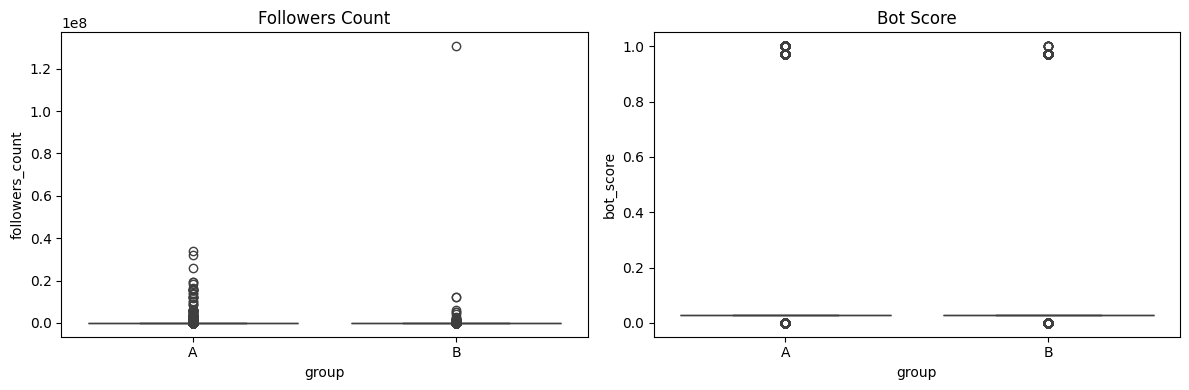

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(x="group", y="followers_count", data=df, ax=axes[0]).set_title("Followers Count")
sns.boxplot(x="group", y="bot_score",        data=df, ax=axes[1]).set_title("Bot Score")
plt.tight_layout()
plt.show()

## 3. Compute Metrics by Group
- **Primary KPI:** average retweets (`retweets`)  
- **Secondary KPIs:** average favorites (`favourites`) and engagement rate

In [10]:
summary_bal = df_bal.groupby("group").agg(
    mean_rt   = ("retweets",  "mean"),
    std_rt    = ("retweets",  "std"),
    n_tweets  = ("retweets",  "count"),
    mean_fav  = ("favourites","mean"),
)
tot_rt     = df_bal.groupby("group")["retweets"].sum()
tot_fav    = df_bal.groupby("group")["favourites"].sum()
tot_follow = df_bal.groupby("group")["followers_count"].sum()
summary_bal["eng_rate"] = (tot_rt + tot_fav) / tot_follow
display(summary_bal.round(3))

,mean_rt,std_rt,n_tweets,mean_fav,eng_rate
group,,,,,
A,12.899,226.579,9432,48.755,0.003
B,2.676,31.726,9432,4.786,0.000


## 4. Statistical Test
- Welch’s t-test for `retweets`  
- Mann–Whitney U as a nonparametric alternative

In [11]:
a_bal = df_bal[df_bal.group=="A"]["retweets"]
b_bal = df_bal[df_bal.group=="B"]["retweets"]

t_stat_bal, p_t_bal = ttest_ind(b_bal, a_bal, equal_var=False)
u_stat_bal, p_u_bal = mannwhitneyu(b_bal, a_bal, alternative="two-sided")

print(f"Balanced Welch t-test: t = {t_stat_bal:.3f}, p = {p_t_bal:.3f}")
print(f"Balanced Mann–Whitney U: U = {u_stat_bal:.3f}, p = {p_u_bal:.3f}")

Balanced Welch t-test: t = -4.339, p = 0.000
Balanced Mann–Whitney U: U = 46963291.000, p = 0.000


## 5. Visualize the Difference
Bar plot of group means with 95% confidence intervals.

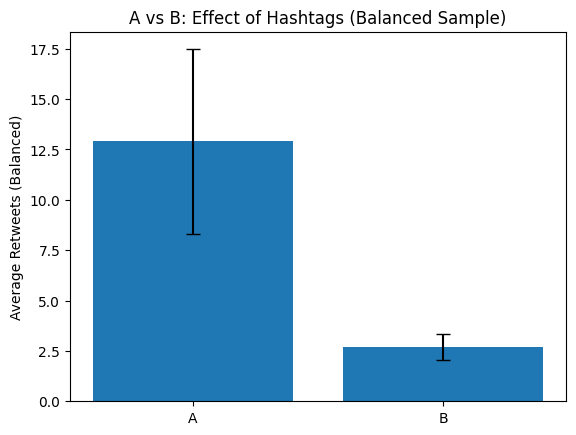

In [12]:
import scipy.stats as st

means = summary_bal["mean_rt"]
ses   = summary_bal["std_rt"] / np.sqrt(summary_bal["n_tweets"])
cis   = st.t.ppf(0.975, summary_bal["n_tweets"]-1) * ses

fig, ax = plt.subplots()
ax.bar(["A","B"], means, yerr=cis, capsize=5)
ax.set_ylabel("Average Retweets (Balanced)")
ax.set_title("A vs B: Effect of Hashtags (Balanced Sample)")
plt.show()

## Final Conclusions: Hashtag A/B Analysis

**Hypothesis:** Appending relevant hashtags to a tweet increases average retweets.

**Results on the balanced sample (9432 tweets per group, stratified by followers_count):**

| Group | mean_rt | std_rt  | n_tweets | mean_fav | eng_rate |
|:-----:|:-------:|:-------:|:--------:|:--------:|:--------:|
| A     | 12.899  | 226.579 | 9432     | 48.755   | 0.003    |
| B     | 2.676   | 31.726  | 9432     | 4.786    | 0.000    |

- **Welch’s t-test:** t = –4.339, p < 0.001  
- **Mann–Whitney U:** U = 4 696 3291, p < 0.001  

Both p-values ≪ 0.05 → the difference remains statistically significant.  
On historical data, tweets **with** hashtags received **fewer** retweets.
